# Artificial Intelligence CA5(P1) Report Codes
## Mohammad Azimpour, 810197657

## Part 1: PreProcess

In [1]:
import numpy as np
import pandas as pd
import pylab
import matplotlib as mpl
#import math

__TrainData=pd.read_csv("Fashion-MNIST/TrainData.csv",header=None)
__TrainLabels=pd.read_csv("Fashion-MNIST/TrainLabels.csv",header=None)
__TestData=pd.read_csv("Fashion-MNIST/TestData.csv",header=None)
__TestLabels=pd.read_csv("Fashion-MNIST/TestLabels.csv",header=None)

TrainData=np.loadtxt(open("Fashion-MNIST/TrainData.csv","rb"),delimiter=',',skiprows=0)
TrainLabels=np.loadtxt(open("Fashion-MNIST/TrainLabels.csv","rb"),delimiter=',',skiprows=0)
TestData=np.loadtxt(open("Fashion-MNIST/TestData.csv","rb"),delimiter=',',skiprows=0)
TestLabels=np.loadtxt(open("Fashion-MNIST/TestLabels.csv","rb"),delimiter=',',skiprows=0)

In [2]:
for i in range(10):
    print("Class:",i)
    print("Data Index",__TrainLabels.groupby(0).get_group(i).index[0])
    print(list(__TrainData.loc[__TrainLabels.groupby(0).get_group(i).index[0]]))

Class: 0
Data Index 1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 54, 48, 43, 87, 168, 133, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 49, 136, 219, 216, 228, 236, 255, 255, 255, 255, 217, 215, 254, 231, 160, 45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 176, 222, 224, 212, 203, 198, 196, 200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164, 0, 0, 0, 0, 0, 0, 0, 0, 0, 188, 219, 200, 198, 202, 198, 199, 199, 201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225, 41, 0, 0, 0, 0, 0, 0, 0, 51, 219, 199, 203, 203, 212, 238, 248, 250, 245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140, 0, 0, 0, 0, 0, 0, 0, 116, 226, 206, 204, 207, 204, 101, 75, 47, 73, 48, 50, 45, 51, 63, 113, 222, 202, 206, 220, 224, 0, 0, 0, 0, 0, 0, 0, 200, 222, 209, 203, 215, 200, 0, 70, 98, 0, 103, 59, 68, 71, 49, 0, 219, 206, 214, 210, 250, 38, 0, 0, 0, 0, 0, 0, 247, 218, 212, 210, 215, 214, 0, 254, 243, 139, 255, 174, 251, 255, 205, 0, 215, 217, 214, 208, 220, 95, 0, 0, 0, 0, 0, 45, 226, 214, 214, 215, 224, 20

Text(0.5, 0.98, 'TestLabels')

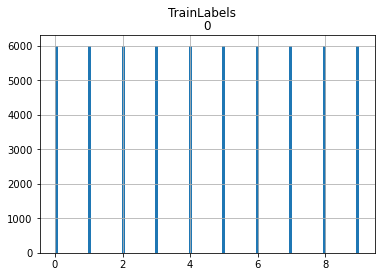

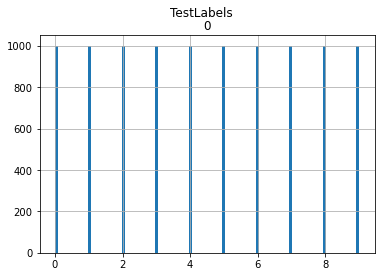

In [3]:
__TrainLabels.hist([0],bins=100)
pylab.suptitle("TrainLabels")
__TestLabels.hist([0],bins=100)
pylab.suptitle("TestLabels")

In [4]:
NormalizedTrainData=np.matrix(TrainData/2550)
NormalizedTestData=np.matrix(TestData/2550)

## Part 2: Neural Network Implementation

### Dataloader

In [5]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors=np.zeros((labels.size,n_classes))
        __labels=labels.astype(int)
        onehot_vectors[np.arange(labels.size),__labels]=1
        return onehot_vectors
    
    def __shuffle_dataset(self):
        if(self.__shuffle):
            shuffler=np.random.permutation(len(self.__data))
            self.__data=self.__data[shuffler]
            self.__onehot_labels=self.__onehot_labels[shuffler]
    
    def __iter__(self):
      
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

### Activation Functions

In [6]:
class Identical:
    
    def __init__(self): pass
    
    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    

class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        temp=np.matrix(matrix,dtype=float)
        relu_value=np.matrix(np.maximum(0,temp),dtype=float)
        #np.where((temp>0),temp,0)
        return relu_value

    def derivative(self, matrix):
        temp=np.matrix(matrix,dtype=float)
        temp[temp<=0]=0
        temp[temp>0]=1
        relu_derivative=np.matrix(temp,dtype=float)
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        temp=np.matrix(matrix,dtype=float)
        leacky_relu_value=np.where((temp>0),temp,self.negative_slope*temp)
        return leacky_relu_value

    def derivative(self, matrix):
        temp=np.matrix(matrix,dtype=float)
        leacky_relu_derivative=np.where((temp>0),1,self.negative_slope)
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        sigmoid_value=np.matrix(1/(1+np.exp(-matrix)),dtype=float)
        return sigmoid_value

    def derivative(self, matrix):
        #sigmoid_derivative=np.matrix(matrix,dtype=float)
        sigmoid_derivative=np.multiply(self.__val(matrix),(1-self.__val(matrix)))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:
    
    def __init__(self): pass

    def __val(self, matrix):
        softmax_value=np.matrix(matrix,dtype=float)
        m=np.max(softmax_value)
        softmax_value=softmax_value-m
        softmax_value=np.exp(softmax_value)
        s=softmax_value.sum()
        softmax_value=softmax_value/s
        return softmax_value

    def __call__(self, matrix):
        return self.__val(matrix)

### Loss Function

In [7]:
class CrossEntropy: #(with softmax)
    
    def __init__(self): pass

    def __val(self, true_val, expected_val):
        _S=Softmax()
        assert np.shape(true_val)==np.shape(expected_val)
        _expected_val=np.matrix(expected_val,dtype=float)
        cross_entropy_value=[]
        for i in range(len(true_val)):
            _true_val=np.log(_S(true_val[i]))
            a=np.array(_expected_val[i])*np.array(_true_val)
            cross_entropy_value.append(sum(-a))
        return cross_entropy_value
        
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        cross_entropy_derivative=np.matrix(true_val,dtype=float)
        _S=Softmax()
        for i in range(len(cross_entropy_derivative)):
            cross_entropy_derivative[i]=_S(cross_entropy_derivative[i])
        cross_entropy_derivative=cross_entropy_derivative-expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

### Layer

In [8]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, input_size, output_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        assert type(initial_weight)==str, 'Undefined activation function!'
        #assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        
        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        #self.__weight=np.vstack((self.__weight,self.__bias))
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
    def forward(self, layer_input):
        self.__last_input=layer_input
        assert np.ndim(layer_input)==2
        assert np.size(self.__weight,0) == np.size(layer_input,1)
        self.__last_activation_input=np.matmul(layer_input,self.__weight)+self.__bias
        self.__last_activation_output=self.__activation(self.__last_activation_input)
        self.__last_activation_derivative=self.__activation.derivative(self.__last_activation_input)
        return self.__last_activation_output
    
    def get_output(self):
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor)==2
        assert np.size(backprop_tensor,0) == np.size(self.__last_activation_derivative,0)
        assert np.size(backprop_tensor,1) == self.__n_neurons
        xt=np.matrix.transpose(self.__last_input)
        wt=np.matrix.transpose(self.__weight)
        bpt=np.multiply(backprop_tensor,self.__last_activation_derivative)
        uw=np.matmul(xt,bpt)
        bias_input=np.matrix(np.array([1. for j in range(len(bpt))]))
        ub=np.matmul(bias_input,bpt)
        #print(np.max(lr*uw),np.min(lr*uw))
        #print(np.max(backprop_tensor),np.min(backprop_tensor))
        self.__weight=self.__weight-lr*uw
        self.__bias=self.__bias-lr*ub
        backprop_tensor=np.matmul(bpt,wt)
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights=np.random.rand(dim1,dim2)
        weights=weights/20
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        # TODO: Implement
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

### Feed Forward Neural Network

In [29]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        
        self.__input_shape = input_shape
        self.__output_shape = None
        
        self.__layers_list = []
        self.pre_last_output = []
        
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        network_output=self.__layers_list[0].forward(network_input)
        for i in range(1,len(self.__layers_list)):
            network_output=self.__layers_list[i].forward(network_output)
        return network_output
    
    def get_pre_last_output(self):
        return self.pre_last_output
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        
        for epoch in range(1, epochs+1):
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
                
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
            
            if type(testloader) != type(None):
                self.pre_last_output = []
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))
                    
        return log
    
    
    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(bach_accuracies), np.mean(batch_losses)

    
    def __train_on_batch(self, x_batch, y_batch):
        network_output=self.forward(x_batch)
        backprop_tensor=self.__loss.derivative(network_output,y_batch)
        batch_accuracy, batch_average_loss=self.__test_on_batch(x_batch, y_batch)
        self.__update_weights(network_output, y_batch)
        for i in range(len(self.__layers_list)-1,0,-1):
            #print(np.shape(backprop_tensor))
            backprop_tensor=self.__layers_list[i].update_weights(backprop_tensor,self.__lr)
        return (batch_accuracy, batch_average_loss)
        
        
    def __test_on_batch(self, x_batch, y_batch):
        network_output=self.forward(x_batch)
        losses=self.__loss(network_output,y_batch)
        batch_average_loss=sum(losses)/len(losses)
        self.pre_last_output.append(np.array(self.__layers_list[-2].get_output()))
        corrects=0.
        for i in range(len(y_batch)):
            if(np.argmax(network_output[i])==np.argmax(y_batch[i])):
                corrects=corrects+1
        batch_accuracy=corrects/len(y_batch)
        return (batch_accuracy, batch_average_loss)
              
        
    def __get_labels(self, outputs):
        # TODO: Implement
        return labels
    
    
    def __compute_accuracy(self, output, expected_output):
        # TODO: Implement
        return accuracy
    
    
    def __update_weights(self, output, y_train):
        cross_entropy = CrossEntropy()
        batch_loss = cross_entropy(output, y_train)
        batch_average_loss = sum(batch_loss)/len(output)
        backprop_tensor = cross_entropy.derivative(output, y_train)
        for i in reversed(self.__layers_list):
            backprop_tensor = i.update_weights(backprop_tensor, self.__lr)
        return

## Part 3: Classification

In [86]:
# Sample code for building and training a model

INPUT_SHAPE = 784
LEARNING_RATE = 0.01
EPOCHS = 300
TRAINLOADER = Dataloader(NormalizedTrainData,TrainLabels,10,128,True)
TESTLOADER = Dataloader(NormalizedTestData,TestLabels,10,128,True)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(20, input_shape=INPUT_SHAPE, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.6700037757640369	Average Loss: 0.08884790441407854
	Test: Average Accuracy: 0.7503955696202531	Average Loss: 0.06565531103135706
Epoch 2:
	Train: Average Accuracy: 0.7980799129353234	Average Loss: 0.05455509341346362
	Test: Average Accuracy: 0.8061708860759493	Average Loss: 0.051895162166532983
Epoch 3:
	Train: Average Accuracy: 0.8249044953802416	Average Loss: 0.04780684375882718
	Test: Average Accuracy: 0.8138844936708861	Average Loss: 0.05105348237260661
Epoch 4:
	Train: Average Accuracy: 0.8352212153518124	Average Loss: 0.04468503315636725
	Test: Average Accuracy: 0.8036985759493671	Average Loss: 0.05081544097481368
Epoch 5:
	Train: Average Accuracy: 0.8448383084577115	Average Loss: 0.04225781171101893
	Test: Average Accuracy: 0.8363330696202531	Average Loss: 0.043982611573824215
Epoch 6:
	Train: Average Accuracy: 0.8506463219616205	Average Loss: 0.04109387809249497
	Test: Average Accuracy: 0.8380142405063291	Average Loss: 0.04499952028904042
Ep

	Train: Average Accuracy: 0.892435145700071	Average Loss: 0.02879076567088669
	Test: Average Accuracy: 0.862440664556962	Average Loss: 0.03808836437558212
Epoch 51:
	Train: Average Accuracy: 0.8915023098791756	Average Loss: 0.028824997668406478
	Test: Average Accuracy: 0.8669897151898734	Average Loss: 0.03866865415592035
Epoch 52:
	Train: Average Accuracy: 0.8921353056147832	Average Loss: 0.02848483433055763
	Test: Average Accuracy: 0.8650118670886076	Average Loss: 0.03872598470843717
Epoch 53:
	Train: Average Accuracy: 0.8927405383795309	Average Loss: 0.0285412707289474
	Test: Average Accuracy: 0.8625395569620253	Average Loss: 0.03948310277045561
Epoch 54:
	Train: Average Accuracy: 0.894583999644634	Average Loss: 0.028256619230098395
	Test: Average Accuracy: 0.8696598101265823	Average Loss: 0.037654012530463604
Epoch 55:
	Train: Average Accuracy: 0.8941453447050463	Average Loss: 0.02829920242145197
	Test: Average Accuracy: 0.8698575949367089	Average Loss: 0.03767125296383684
Epoch 56:

	Train: Average Accuracy: 0.9050617448471926	Average Loss: 0.025376502559783787
	Test: Average Accuracy: 0.8592761075949367	Average Loss: 0.041182888426452714
Epoch 100:
	Train: Average Accuracy: 0.904178882373845	Average Loss: 0.025414053818230205
	Test: Average Accuracy: 0.8706487341772152	Average Loss: 0.039238923413372796
Epoch 101:
	Train: Average Accuracy: 0.9038013059701493	Average Loss: 0.025567804414145332
	Test: Average Accuracy: 0.8685719936708861	Average Loss: 0.04024610987141486
Epoch 102:
	Train: Average Accuracy: 0.9040789356787491	Average Loss: 0.025593021115666637
	Test: Average Accuracy: 0.8613528481012658	Average Loss: 0.04068771945956016
Epoch 103:
	Train: Average Accuracy: 0.9036236229566453	Average Loss: 0.025525271163068585
	Test: Average Accuracy: 0.8612539556962026	Average Loss: 0.04111285363368917
Epoch 104:
	Train: Average Accuracy: 0.9040567253020612	Average Loss: 0.025546523648726782
	Test: Average Accuracy: 0.869560917721519	Average Loss: 0.040286874643701

	Train: Average Accuracy: 0.9096259772565742	Average Loss: 0.024067210009228155
	Test: Average Accuracy: 0.8654074367088608	Average Loss: 0.04315324670726487
Epoch 149:
	Train: Average Accuracy: 0.9106698649609097	Average Loss: 0.02357567281089807
	Test: Average Accuracy: 0.866495253164557	Average Loss: 0.04249197738694872
Epoch 150:
	Train: Average Accuracy: 0.9102256574271499	Average Loss: 0.023631360345920976
	Test: Average Accuracy: 0.8677808544303798	Average Loss: 0.04233566549789136
Epoch 151:
	Train: Average Accuracy: 0.9092706112295665	Average Loss: 0.02404591372349758
	Test: Average Accuracy: 0.8736155063291139	Average Loss: 0.04103863197163164
Epoch 152:
	Train: Average Accuracy: 0.9113917022032694	Average Loss: 0.023705284118539127
	Test: Average Accuracy: 0.8666930379746836	Average Loss: 0.04331136662121104
Epoch 153:
	Train: Average Accuracy: 0.91017013148543	Average Loss: 0.023739889493885374
	Test: Average Accuracy: 0.8643196202531646	Average Loss: 0.04468740563032862
Ep

	Train: Average Accuracy: 0.9150508617626155	Average Loss: 0.022583957616202476
	Test: Average Accuracy: 0.8663963607594937	Average Loss: 0.044485585006832376
Epoch 198:
	Train: Average Accuracy: 0.9161835909737029	Average Loss: 0.0223639448647327
	Test: Average Accuracy: 0.8665941455696202	Average Loss: 0.04542803879815268
Epoch 199:
	Train: Average Accuracy: 0.9146954957356077	Average Loss: 0.02260746592858427
	Test: Average Accuracy: 0.8684731012658228	Average Loss: 0.04468966738028272
Epoch 200:
	Train: Average Accuracy: 0.9136571606254442	Average Loss: 0.022911305797101073
	Test: Average Accuracy: 0.8621439873417721	Average Loss: 0.04515435085817017
Epoch 201:
	Train: Average Accuracy: 0.9153395966595593	Average Loss: 0.022334123406919412
	Test: Average Accuracy: 0.8687697784810127	Average Loss: 0.04281710300003735
Epoch 202:
	Train: Average Accuracy: 0.9153340440653874	Average Loss: 0.022616557268794895
	Test: Average Accuracy: 0.8703520569620253	Average Loss: 0.0434515620060135


	Train: Average Accuracy: 0.9183990760483298	Average Loss: 0.021548446907827184
	Test: Average Accuracy: 0.864121835443038	Average Loss: 0.046972976593713946
Epoch 247:
	Train: Average Accuracy: 0.9186656005685857	Average Loss: 0.021473691726297962
	Test: Average Accuracy: 0.8694620253164557	Average Loss: 0.046372479065603676
Epoch 248:
	Train: Average Accuracy: 0.9200093283582089	Average Loss: 0.02131919867968548
	Test: Average Accuracy: 0.8658030063291139	Average Loss: 0.046720867392095425
Epoch 249:
	Train: Average Accuracy: 0.9182324982231699	Average Loss: 0.021779491303515402
	Test: Average Accuracy: 0.8692642405063291	Average Loss: 0.04629071001666489
Epoch 250:
	Train: Average Accuracy: 0.9187044687277895	Average Loss: 0.021475622178270645
	Test: Average Accuracy: 0.859375	Average Loss: 0.049331052762270074
Epoch 251:
	Train: Average Accuracy: 0.9187599946695096	Average Loss: 0.021670206180270563
	Test: Average Accuracy: 0.8675830696202531	Average Loss: 0.046988911295040556
Epoc

	Train: Average Accuracy: 0.9212475568585644	Average Loss: 0.02085416207120533
	Test: Average Accuracy: 0.8517602848101266	Average Loss: 0.05276526952413344
Epoch 296:
	Train: Average Accuracy: 0.9214752132196162	Average Loss: 0.02089872338302004
	Test: Average Accuracy: 0.8670886075949367	Average Loss: 0.050198085205592144
Epoch 297:
	Train: Average Accuracy: 0.9216251332622601	Average Loss: 0.020660449071817938
	Test: Average Accuracy: 0.8663963607594937	Average Loss: 0.050450845160566776
Epoch 298:
	Train: Average Accuracy: 0.9196539623312011	Average Loss: 0.020966312467889995
	Test: Average Accuracy: 0.858682753164557	Average Loss: 0.050126698551657065
Epoch 299:
	Train: Average Accuracy: 0.9203646943852168	Average Loss: 0.020832794406468156
	Test: Average Accuracy: 0.8681764240506329	Average Loss: 0.04903498332839538
Epoch 300:
	Train: Average Accuracy: 0.9217139747690121	Average Loss: 0.020763477853507965
	Test: Average Accuracy: 0.8500791139240507	Average Loss: 0.055644904187766

### Phase 3, Step 5:

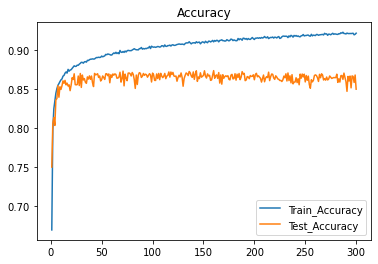

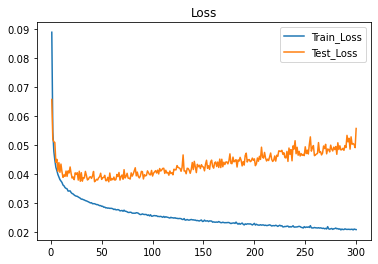

In [88]:
epch=np.linspace(1,300,300)
mpl.pyplot.figure(1)
mpl.pyplot.plot(epch,log['train_accuracy'])
mpl.pyplot.plot(epch,log['test_accuracy'])
mpl.pyplot.legend(["Train_Accuracy","Test_Accuracy"])
mpl.pyplot.title("Accuracy")
mpl.pyplot.savefig("Step5-Accuracy.jpeg")
mpl.pyplot.show()
mpl.pyplot.close()
mpl.pyplot.figure(2)
mpl.pyplot.plot(epch,log['train_loss'])
mpl.pyplot.plot(epch,log['test_loss'])
mpl.pyplot.legend(["Train_Loss","Test_Loss"])
mpl.pyplot.title("Loss")
mpl.pyplot.savefig("Step5-Loss.jpeg")
mpl.pyplot.show()
mpl.pyplot.close()

## Phase 4: Plotting Dimension-Reduced Datas

In [76]:
INPUT_SHAPE = 784
LEARNING_RATE = 0.001
EPOCHS = 10
TRAINLOADER = Dataloader(NormalizedTrainData,TrainLabels,10,32,True)
TESTLOADER = Dataloader(NormalizedTestData,TestLabels,10,32,False)

network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(784, input_shape=INPUT_SHAPE, activation=Identical(), weight_initializer='uniform')
network.add_layer(2, activation=Identical(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.29433333333333334	Average Loss: 0.1798033023273005
	Test: Average Accuracy: 0.47324281150159747	Average Loss: 0.12086063091590513
Epoch 2:
	Train: Average Accuracy: 0.5663166666666667	Average Loss: 0.10851884699371309
	Test: Average Accuracy: 0.6299920127795527	Average Loss: 0.10006362391221449
Epoch 3:
	Train: Average Accuracy: 0.6304666666666666	Average Loss: 0.09355128422584222
	Test: Average Accuracy: 0.6312899361022364	Average Loss: 0.09351570149427058
Epoch 4:
	Train: Average Accuracy: 0.6582666666666667	Average Loss: 0.08773946795324701
	Test: Average Accuracy: 0.6333865814696485	Average Loss: 0.09101884987546428
Epoch 5:
	Train: Average Accuracy: 0.6753	Average Loss: 0.08434499572022672
	Test: Average Accuracy: 0.6736222044728435	Average Loss: 0.08280539091949025
Epoch 6:
	Train: Average Accuracy: 0.6906666666666667	Average Loss: 0.0816201275108517
	Test: Average Accuracy: 0.6883985623003195	Average Loss: 0.0832563369346882
Epoch 7:
	Train: 

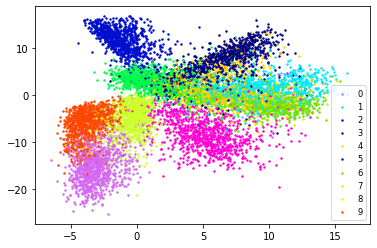

In [77]:
pre_last_output=network.get_pre_last_output()
mpl.pyplot.figure(3)
colormap = mpl.cm.gist_ncar
colors = [colormap(i) for i in [0,25,50,75,100,125,150,175,200,225,250]]
for i in range(len(pre_last_output)):
    for j in range(len(pre_last_output[i])):
        mpl.pyplot.scatter(pre_last_output[i][j][0],pre_last_output[i][j][1],s=2,color=colors[int(TestLabels[i*32+j])])
mpl.pyplot.legend([0,1,2,3,4,5,6,7,8,9],fontsize='small') 
mpl.pyplot.savefig("4.jpeg")
#input()
mpl.pyplot.show()
mpl.pyplot.close()